# Introduction

## Setup

In [1]:
import os
import random
from glob import glob

import pandas as pd
import plotnine as p9

import torchaudio

CONVERSATIONS = "data/conversations"

p9.theme_set(
    p9.theme_minimal() + 
    p9.theme(
        figure_size=(12, 6),
        panel_background = p9.element_rect(fill='white'),
        plot_background = p9.element_rect(fill='white'),
        plot_title=p9.element_text(color='black', size=16, weight='bold'),
        axis_line=p9.element_line(color='black'),
        axis_title=p9.element_text(color='black', size=14),
        axis_text=p9.element_text(color='black', size=12),
        axis_ticks=p9.element_line(color='black')
    )
)

# Dataset exploration

Let's begin with visualizing the waveform for a random conversation.

In [63]:
# why 42? because 42 is the answer to life, the universe and everything (according to The Hitchhiker's Guide to the Galaxy)
random.seed(42)

conversations = glob(os.path.join(CONVERSATIONS, "*"))
audio_files = [glob(os.path.join(c, "processed", "*.mp3"))[0] for c in conversations]
random_conversation = random.sample(audio_files, 1)[0]

print("Random conversation:", random_conversation)

Random conversation: data/conversations/67836c1d-1334-41a0-a33a-4f788e8b6fb3/processed/67836c1d-1334-41a0-a33a-4f788e8b6fb3.mp3




Profession grade audio use a default sampling rate of 48KHz (like here). We might have to use a smaller sampling rate, just so that it's easier to plot the waveform.

In [35]:
# load the audio file
yt, sr = torchaudio.load(random_conversation)

# Print audio file details
print("Number of channels:", yt.shape[0])
print("Number of samples:", yt.shape[1])
if yt.shape[0] > 1:
    yt = yt.mean(dim=0) # Convert to mono by averaging channels if stereo

print("Sample rate:", sr)
print("Duration (minutes):", yt.shape[0] / sr / 60)

/home/ssubrahmanya/.local/lib/python3.9/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.


Number of channels: 2
Number of samples: 83189423
Sample rate: 48000
Duration (minutes): 28.885216319444446


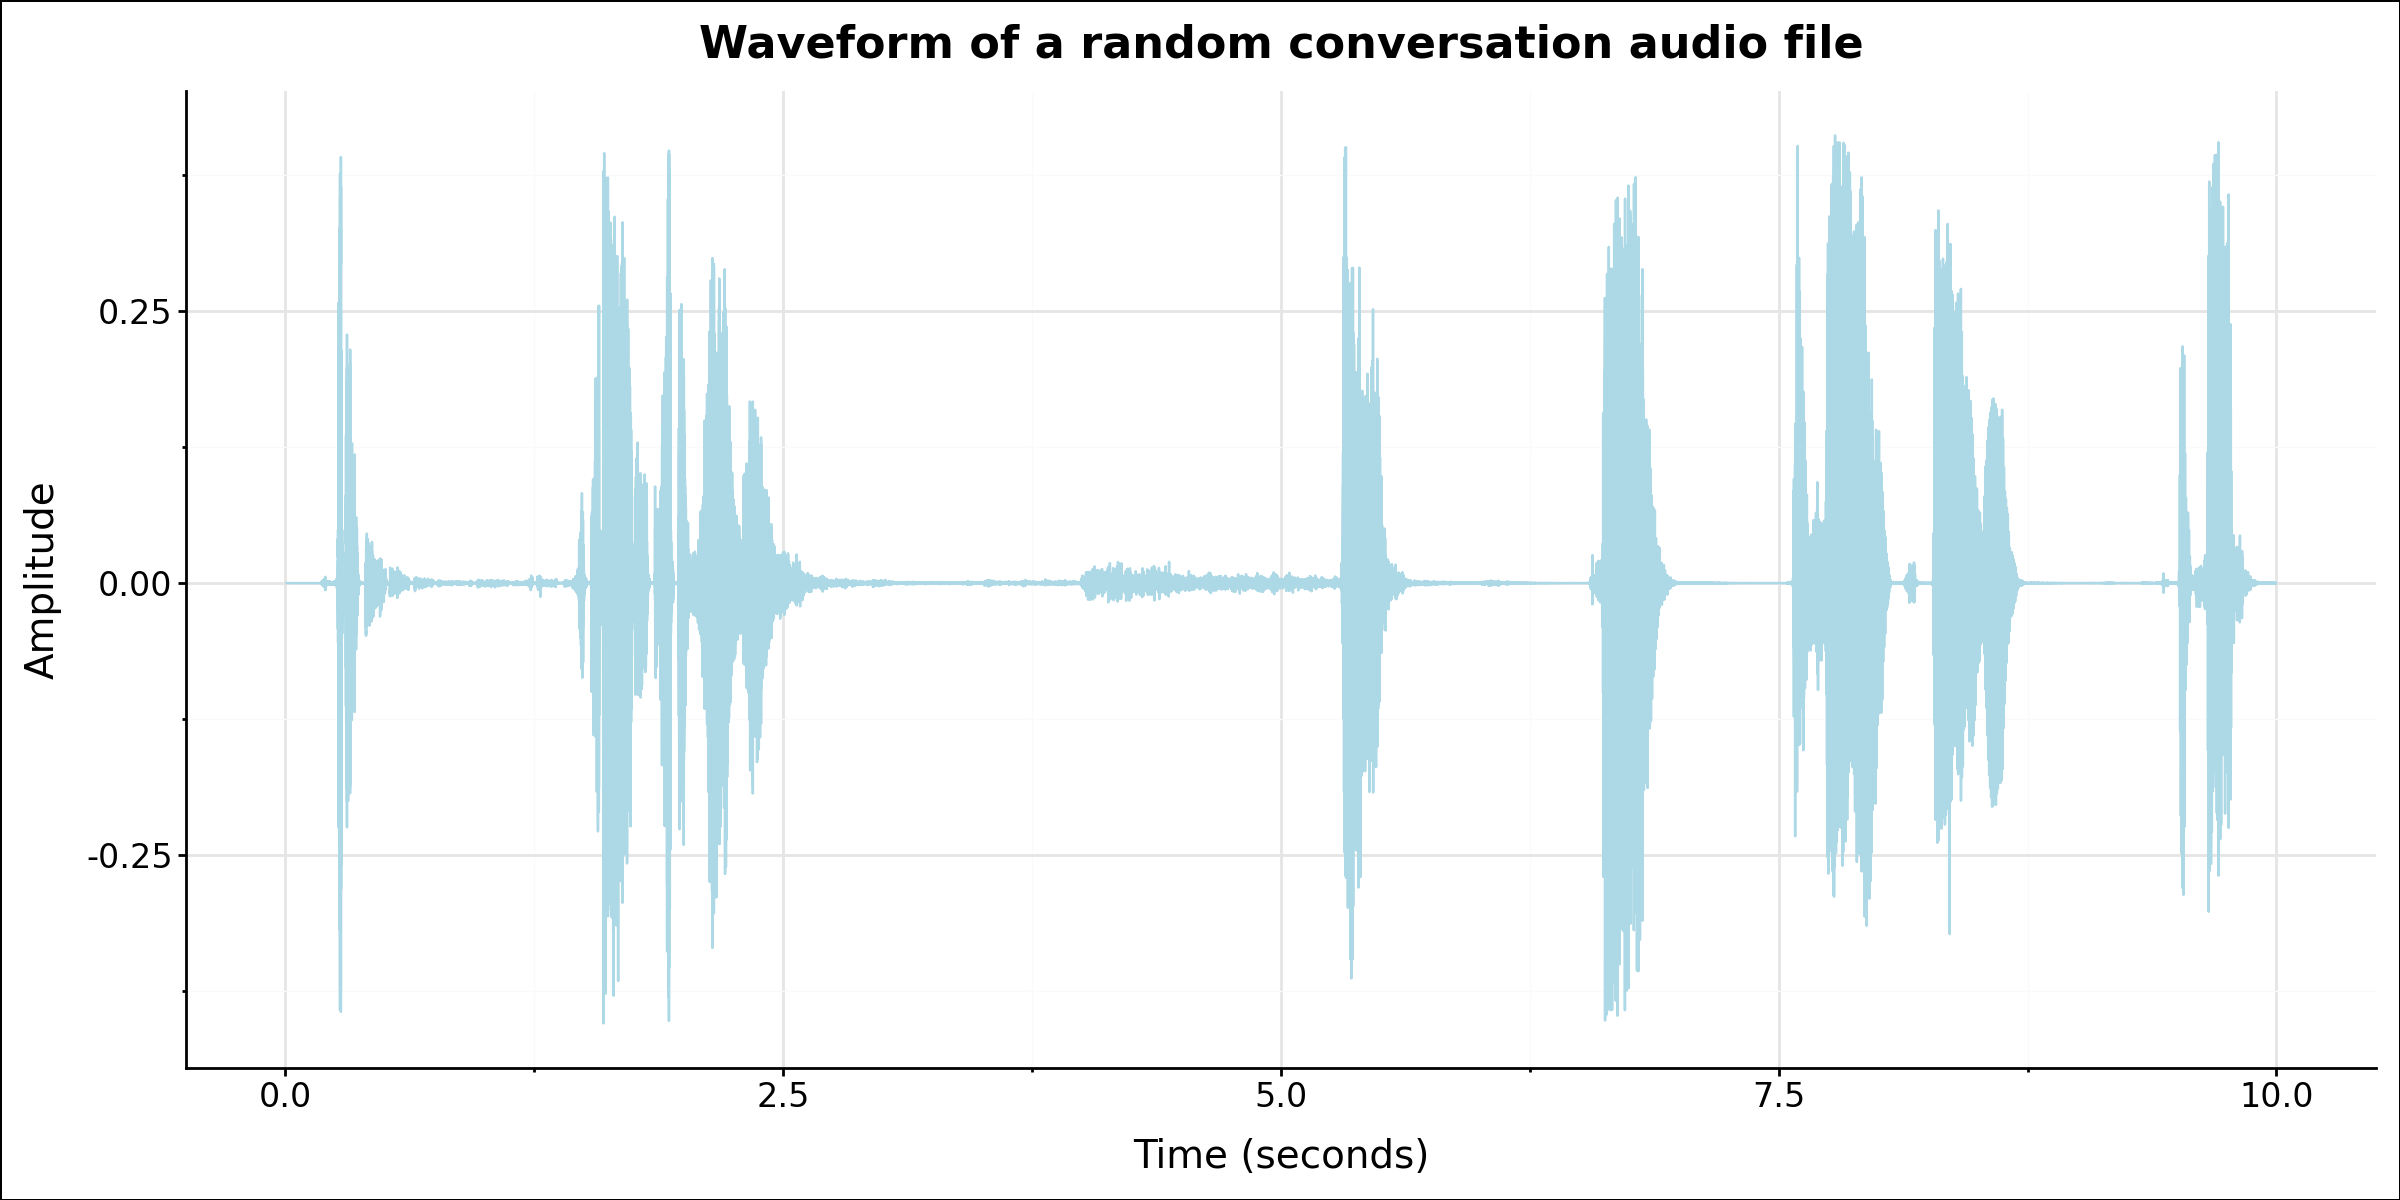

In [36]:
def plot_waveform(yt, sr, start=0, end=None):
    
    if end is None: end = yt.shape[0]
    
    points = pd.DataFrame({
        "Sample Index": range(start, end),
        "Time": [i / sr for i in range(start, end)],
        "Amplitude": yt[start:end]
    })
    
    plot = (
        p9.ggplot(points, p9.aes(x="Time", y="Amplitude"))
        + p9.geom_line(color="lightblue", size=0.5)
        + p9.labs(
            title="Waveform of a random conversation audio file", 
            x="Time (seconds)", 
            y="Amplitude")
    )

    return plot

# Plot the first 10 seconds of the audio
start = 0
end = sr * 10  # first 10 seconds
plot_waveform(yt, sr, start, end)

Data preprocessing methods used by [Di Stasi et al. (2023)](https://psycnet.apa.org/record/2024-16512-001).

1. Each negotiation session was recorded as a single file (similar to CANDOR). The authors used [Trint](https://trint.com) software for ASR and generate transcripts to their utterrance, and NLP to annotate the speaker turns -- thus there's a step transcript generation here.

2. In the other method, they recorded separate audio files for both speakers and used Trint for automatic VAD on both files.

<br/>

| Metrics       | Speech processing steps |
|---------------|-------------------------|
| Speaking time |                   |
| Turn length   | Data 2                  |
| Pauses        | Data 3                  |
| Speech rate   | Data 4                  |
| Interruptions | Data 5                  |
| Backchannels  | Data 6                  |
| Response time | Data 7                  |

phonemes (?)

In [65]:
from convodynamics.preprocess import diarize_audio, remove_shortest_speaker

segments, total_duration = diarize_audio(random_conversation)

# remove the shortest speaker
segments = remove_shortest_speaker(segments)

/data/candor/convodynamics/preprocess.py:30: UserWarning: torchaudio._backend.utils.info has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
/home/ssubrahmanya/.local/lib/python3.9/site-packages/torchaudio/_backend/soundfile_backend.py:71: UserWarning: The MPEG_LAYER_III subtype is unknown to TorchAudio. As a result, the bits_per_sample attribute will be set to 0. If you are seeing this warning, please report by opening an issue on github (after checking for existing/closed ones). You may otherwise ignore this warning.
/home/ssubrahmanya/.local/lib/python3.9/site-packages/torchaudio/_backend/soundfile_backend.py:120: UserWarning: torchaudio._backend.common.AudioMetaData has been de

In [ ]:
# Prepare waveform data
points = pd.DataFrame({
    "Sample Index": range(start, end),
    "Time": [i / sr for i in range(start, end)],
    "Amplitude": yt[start:end]
})

# Prepare segment data for plotting (only those within the plotted range)
segments_plot = segments.loc[(segments['end'] > points['Time'].min()) & (segments['start'] < points['Time'].max())]
segments_plot['start'] = segments_plot['start'].clip(lower=points['Time'].min())
segments_plot['end'] = segments_plot['end'].clip(upper=points['Time'].max())

# Assign a color to each speaker
# speakers = segments_plot['speaker'].unique()
speaker_colors = {s: c for s, c in zip(segments_plot['speaker'].unique(), ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"])}

# Plot
(
    p9.ggplot(points, p9.aes(x="Time", y="Amplitude"))
    + p9.geom_line(color="black", size=0.5)
    + p9.geom_rect(
        data=segments_plot,
        mapping=p9.aes(xmin="start", xmax="end", ymin=-1, ymax=1, fill="speaker"),
        alpha=0.2,
        inherit_aes=False
    )
    + p9.scale_fill_manual(values=speaker_colors)
    + p9.labs(
        title="Waveform with Speaker Annotations",
        x="Time (seconds)",
        y="Amplitude",
        fill="Speaker"
    )
)

/tmp/ipykernel_3188658/2968628178.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_3188658/2968628178.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,start,end,speaker,duration
1,6.561594,6.966594,SPEAKER_02,0.405


In [6]:
from convodynamics.macro_metrics import SpeakingTime, TurnLength, Pauses
from convodynamics.feature_extractor import FeatureExtractor


# register and extract features
speaking_time = SpeakingTime()
turn_length = TurnLength()
pauses = Pauses()

fe = FeatureExtractor()
fe.register_metrics([speaking_time, turn_length, pauses])
features = fe.extract(segments, total_duration)

features

{'speaking_time': {'speaker_00_speaking_time': 28.84336630150682,
  'speaker_02_speaking_time': 38.156629599414224},
 'turn_length': {'speaker_00_turn_length_median': 1.248749999999994,
  'speaker_02_turn_length_median': 1.2487499999999727,
  'speaker_00_turn_length_mean': 1.930069980694978,
  'speaker_02_turn_length_mean': 1.6912979539641892,
  'speaker_00_turn_length_cv': 0.9697565860059273,
  'speaker_02_turn_length_cv': 0.7855176166891813,
  'speaker_02_turn_length_predictability': 0.007822116008573386,
  'speaker_00_turn_length_predictability': 0.05134583787117663,
  'turn_length_adaptability': nan},
 'pauses': {'speaker_00_avg_pause_pct': 0.04721791240252848,
  'speaker_02_avg_pause_pct': 0.05212940814141024}}

In [66]:
from convodynamics.preprocess import remove_shortest_speaker

if segments['speaker'].nunique() > 2:
    segments = remove_shortest_speaker(segments)

def is_backchannel(current_segment, segments):

    check = any(
        # check if current segment is within another segment
        (segments["start"] <= current_segment["start"]) & \
        (segments["end"] >= current_segment["end"]) & \
        # check if current segment is <= 1 second
        (current_segment["end"] - current_segment["start"] <= 1.0)
    )

    return check

segments['backchannel'] = segments.apply(is_backchannel, args=(segments,), axis=1)

segments.head()

,start,end,speaker,duration,backchannel
1,6.561594,6.966594,SPEAKER_02,0.405000,True
3,10.645344,11.387844,SPEAKER_02,0.742500,True
4,11.573469,12.737844,SPEAKER_02,1.164375,False
5,13.767219,16.737219,SPEAKER_02,2.970000,False
6,17.631594,18.424719,SPEAKER_02,0.793125,True


In [81]:
turns = segments.groupby("speaker").size().astype(float)
backchannels = segments.groupby("speaker")["backchannel"].sum().astype(float)

speakers = segments["speaker"].unique()
backchannels.loc[speakers[0]] = backchannels.loc[speakers[0]] * 100 / turns.loc[speakers[1]]
backchannels.loc[speakers[1]] = backchannels.loc[speakers[1]] * 100 / turns.loc[speakers[0]]

backchannels


speaker
SPEAKER_00    27.877238
SPEAKER_02    61.776062
Name: backchannel, dtype: float64